<a href="https://colab.research.google.com/github/Gavinug/-5-day-coding-marathon/blob/main/AI_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load both sheets from the Excel file
ocr_df = pd.read_excel('lab_report_datasets.xlsx', sheet_name='OCR_Dataset')
nlp_df = pd.read_excel('lab_report_datasets.xlsx', sheet_name='NLP_Dataset')

# Display basic info
print("OCR Dataset Info:")
print(ocr_df.info())
print("\nNLP Dataset Info:")
print(nlp_df.info())

# Display sample data
print("\nOCR Dataset Sample:")
print(ocr_df.head())
print("\nNLP Dataset Sample:")
print(nlp_df.head())

OCR Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Image_Path       50 non-null     object
 1   Report_Text      50 non-null     object
 2   Patient_ID       50 non-null     object
 3   Patient_Name     50 non-null     object
 4   Collection_Date  50 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB
None

NLP Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Patient_ID       605 non-null    object 
 1   Patient_Name     605 non-null    object 
 2   DOB              605 non-null    object 
 3   Gender           605 non-null    object 
 4   Collection_Date  605 non-null    object 
 5   Test_Name        605 non-null    object 
 6   Test_Value       605 no

In [ ]:
import re
from datetime import datetime

def extract_test_results(text):
    """Extract test results from the report text"""
    results = {}
    test_section = re.search(r'TEST RESULTS:.*?(?=Physician:|$)', text, re.DOTALL)
    if test_section:
        test_lines = test_section.group(0).split('\n')
        for line in test_lines:
            if ':' in line and ('HIGH' in line or 'LOW' in line or 'NORMAL' in line):
                parts = line.split(':')
                test_name = parts[0].strip()
                rest = ':'.join(parts[1:]).strip()

                # Extract value, unit, and flag
                value_match = re.search(r'([\d.]+)\s*([^\(\)]*)\(', rest)
                if value_match:
                    value = float(value_match.group(1))
                    unit = value_match.group(2).strip()
                else:
                    value = None
                    unit = None

                flag = 'HIGH' if 'HIGH' in rest else 'LOW' if 'LOW' in rest else 'NORMAL'

                results[test_name] = {
                    'value': value,
                    'unit': unit,
                    'flag': flag
                }
    return results

# Process OCR data
ocr_df['test_results'] = ocr_df['Report_Text'].apply(extract_test_results)

# Process NLP data - already structured
nlp_df['Collection_Date'] = pd.to_datetime(nlp_df['Collection_Date'])
nlp_df['DOB'] = pd.to_datetime(nlp_df['DOB'])
nlp_df['age'] = (nlp_df['Collection_Date'] - nlp_df['DOB']).dt.days / 365.25

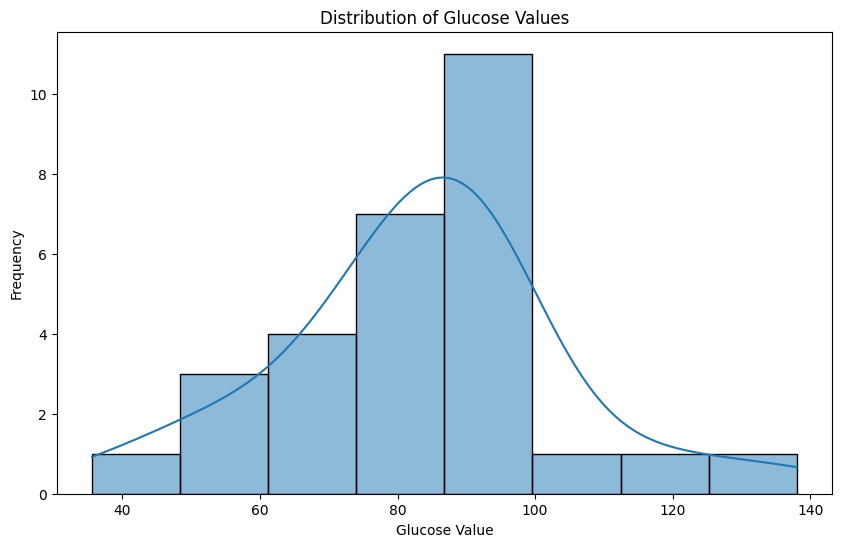

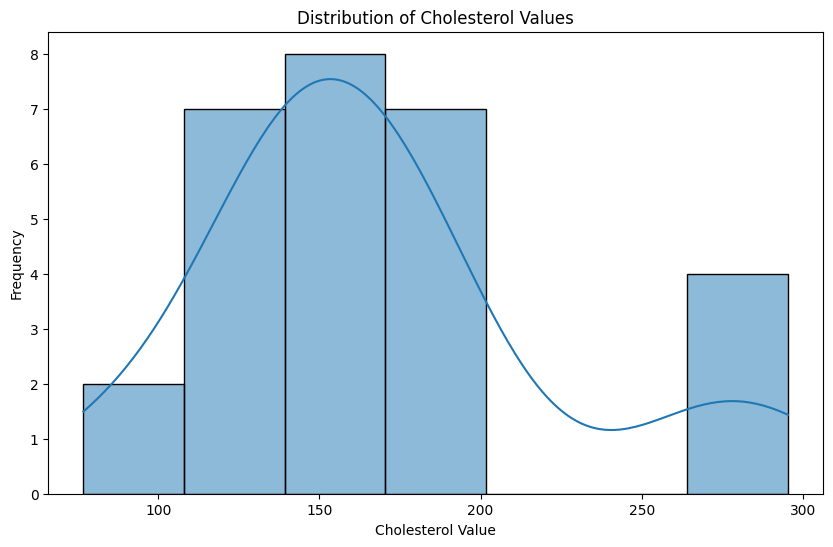

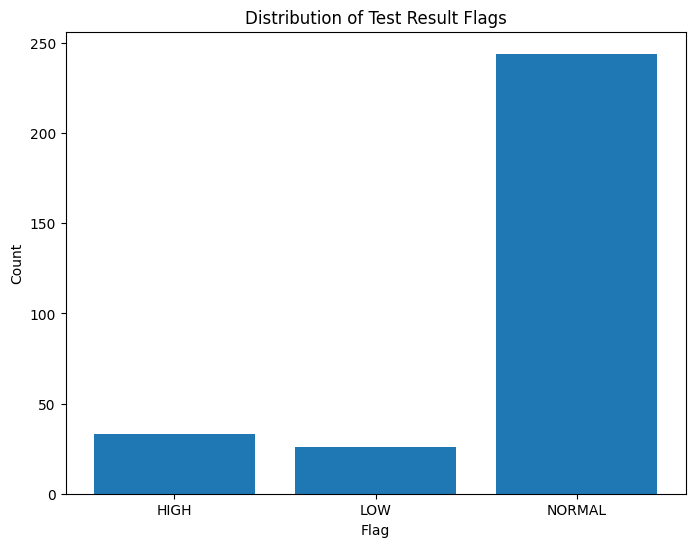

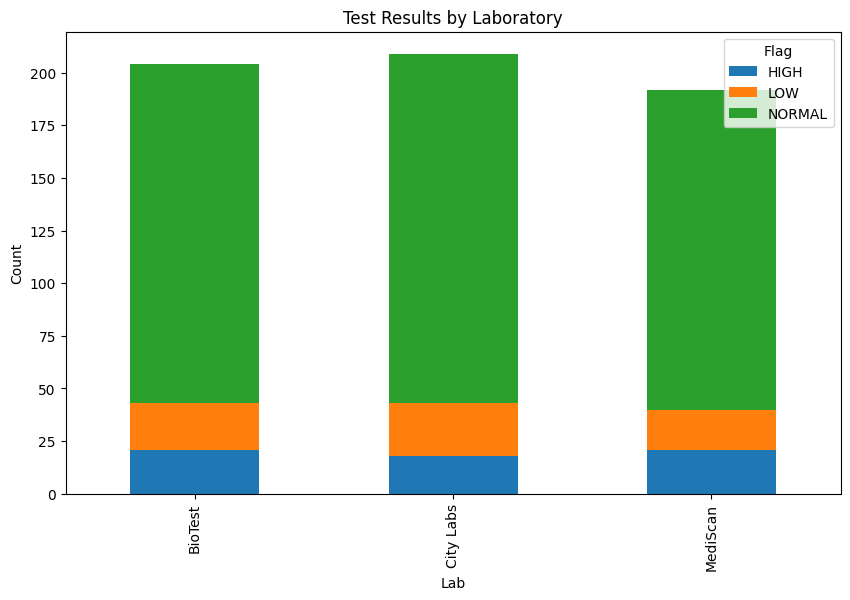

In [ ]:
# Analyze test result distributions
def plot_test_distributions(df, test_name):
    values = []
    for results in df['test_results']:
        if test_name in results:
            values.append(results[test_name]['value'])

    if values:
        plt.figure(figsize=(10, 6))
        sns.histplot(values, kde=True)
        plt.title(f'Distribution of {test_name} Values')
        plt.xlabel(f'{test_name} Value')
        plt.ylabel('Frequency')
        plt.show()

# Example usage
plot_test_distributions(ocr_df, 'Glucose')
plot_test_distributions(ocr_df, 'Cholesterol')

# Analyze abnormal flags
def analyze_abnormal_results(df):
    abnormal_counts = {'HIGH': 0, 'LOW': 0, 'NORMAL': 0}
    for results in df['test_results']:
        for test, data in results.items():
            abnormal_counts[data['flag']] += 1

    plt.figure(figsize=(8, 6))
    plt.bar(abnormal_counts.keys(), abnormal_counts.values())
    plt.title('Distribution of Test Result Flags')
    plt.xlabel('Flag')
    plt.ylabel('Count')
    plt.show()

analyze_abnormal_results(ocr_df)

# Compare labs
lab_comparison = nlp_df.groupby(['Lab', 'Flag']).size().unstack().fillna(0)
lab_comparison.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Test Results by Laboratory')
plt.ylabel('Count')
plt.show()

In [ ]:
!pip install pytesseract

In [ ]:
!pip install pytesseract opencv-python pillow


In [ ]:
import pytesseract
from PIL import Image
import cv2
import numpy as np
import re

def extract_test_results(text):
    """Extract test results from OCR text"""
    test_results = {}

    # Split text into lines
    lines = text.split('\n')

    # Find the TEST RESULTS section
    start_processing = False
    for line in lines:
        if "TEST RESULTS" in line:
            start_processing = True
            continue
        if "Lab Director:" in line:
            break

        if start_processing and line.strip():
            # Split line into components (this is a simple approach)
            parts = [p for p in line.split(' ') if p]
            if len(parts) >= 4 and parts[0] != "TEST":
                test_name = ' '.join(parts[:-3])
                value = parts[-3]
                unit = parts[-2]
                ref_range = parts[-1]

                test_results[test_name] = {
                    'value': value,
                    'unit': unit,
                    'reference_range': ref_range
                }

    return test_results

def process_lab_report_image(image_path):
    """Process a new lab report image and extract structured data"""
    # Load and preprocess image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # OCR processing
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(thresh, config=custom_config)

    # Extract structured data
    patient_info = {}
    test_results = {}

    # Extract patient ID, name, etc.
    patient_match = re.search(r'Patient:\s*(.*)', text)
    if patient_match:
        patient_info['Patient_Name'] = patient_match.group(1).strip()

    id_match = re.search(r'ID:\s*(.*)', text)
    if id_match:
        patient_info['Patient_ID'] = id_match.group(1).strip()

    dob_match = re.search(r'DOB:\s*(.*)', text)
    if dob_match:
        patient_info['Date_of_Birth'] = dob_match.group(1).strip()

    # Extract test results
    test_results = extract_test_results(text)

    return {
        'patient_info': patient_info,
        'test_results': test_results,
        'raw_text': text
    }

# Example usage with your image
result = process_lab_report_image("lab_report.png")
print("Patient Information:", result['patient_info'])
print("\nTest Results:")
for test, values in result['test_results'].items():
    print(f"{test}: {values['value']} {values['unit']} (Ref: {values['reference_range']})")

Patient Information: {'Patient_Name': 'John Doe', 'Patient_ID': '824964', 'Date_of_Birth': '9/10/1970'}

Test Results:
Complete Blood Count (CBC): 129 mg/d. (Ref: 120-150)
Hemoglobin (Hb): 175 gid. (Ref: 13.5-17.5)
White Blood Cells (WBC): 6.18 40"3uL (Ref: 4511.0)
Platelets: 139, s0*3fuL (Ref: 150-450)
Glucose: 75.3 mgd (Ref: 70-99)


In [ ]:
import spacy
from spacy import displacy

# Load English language model
nlp = spacy.load("en_core_web_sm")

def analyze_report_text(text):
    """Analyze report text with NLP"""
    doc = nlp(text)

    # Extract entities
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Extract key phrases
    key_phrases = []
    for sent in doc.sents:
        for noun_chunk in sent.noun_chunks:
            key_phrases.append(noun_chunk.text)

    return {
        'entities': entities,
        'key_phrases': list(set(key_phrases))
    }

# Example usage on OCR data
sample_report = ocr_df['Report_Text'].iloc[0]
analysis = analyze_report_text(sample_report)
print("Entities found:", analysis['entities'])
print("Key phrases:", analysis['key_phrases'])

# Visualize named entities
doc = nlp(sample_report)
displacy.render(doc, style="ent", jupyter=True)

Entities found: [('1aac49a4', 'CARDINAL'), ('5.57 %', 'PERCENT'), ('4.0-5.6', 'CARDINAL'), ('128.68', 'CARDINAL'), ('120-200', 'CARDINAL'), ('7.03', 'CARDINAL'), ('x10³/μL', 'PERSON'), ('Ref', 'ORG'), ('4.0-10.0', 'CARDINAL'), ('57.5', 'CARDINAL'), ('70-99', 'CARDINAL'), ('126.8', 'CARDINAL'), ('50-130', 'CARDINAL'), ('RBC', 'ORG'), ('5.85 x10⁶/μL', 'QUANTITY'), ('4.5', 'CARDINAL'), ('143.99', 'CARDINAL'), ('135-145', 'CARDINAL'), ('3.6', 'CARDINAL'), ('3.5-5.2', 'CARDINAL'), ('Torres', 'PERSON')]
Key phrases: ['3.6 mmol/L', '126.8 mg', '(Ref', 'NORMAL\nGlucose', 'NORMAL\n\nPhysician', '(Ref: 70-99) LOW\nLDL', '5.57 %', 'HbA1c', 'NORMAL\nWBC', 'Willie Love\nID', 'NORMAL\nRBC', 'F\nCollection Date', 'dL', '08/25/1981\nGender', '1aac49a4\nDOB', 'NORMAL\nPotassium', '02/15/2025\n\nTEST RESULTS', '143.99 mmol/L', 'NORMAL\nCholesterol', '128.68 mg/dL', 'Ref', '7.03 x10³/μL', '5.85 x10⁶/μL', 'Dr. Torres\nLab: BioTest\nReport Date']


In [ ]:
from flask import Flask, request, render_template, jsonify
import os
from werkzeug.utils import secure_filename

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads/'
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400

    if file:
        filename = secure_filename(file.filename)
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(filepath)

        # Process the report
        report_data = process_lab_report_image(filepath)

        # Add analysis
        analysis = analyze_report_text(report_data['raw_text'])
        report_data['analysis'] = analysis

        return jsonify(report_data)

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
